
Kwh Data Distribution Statistics:
count    1.040947e+06
mean     2.872555e+01
std      4.298511e+01
min      0.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      5.300000e+01
max      1.770000e+02
Name: Kwh, dtype: float64
Number of zero Kwh values: 196733
Minimum non-zero Kwh value: 1.0
Percentage of Kwh values <= 0.1: 18.761938821734258


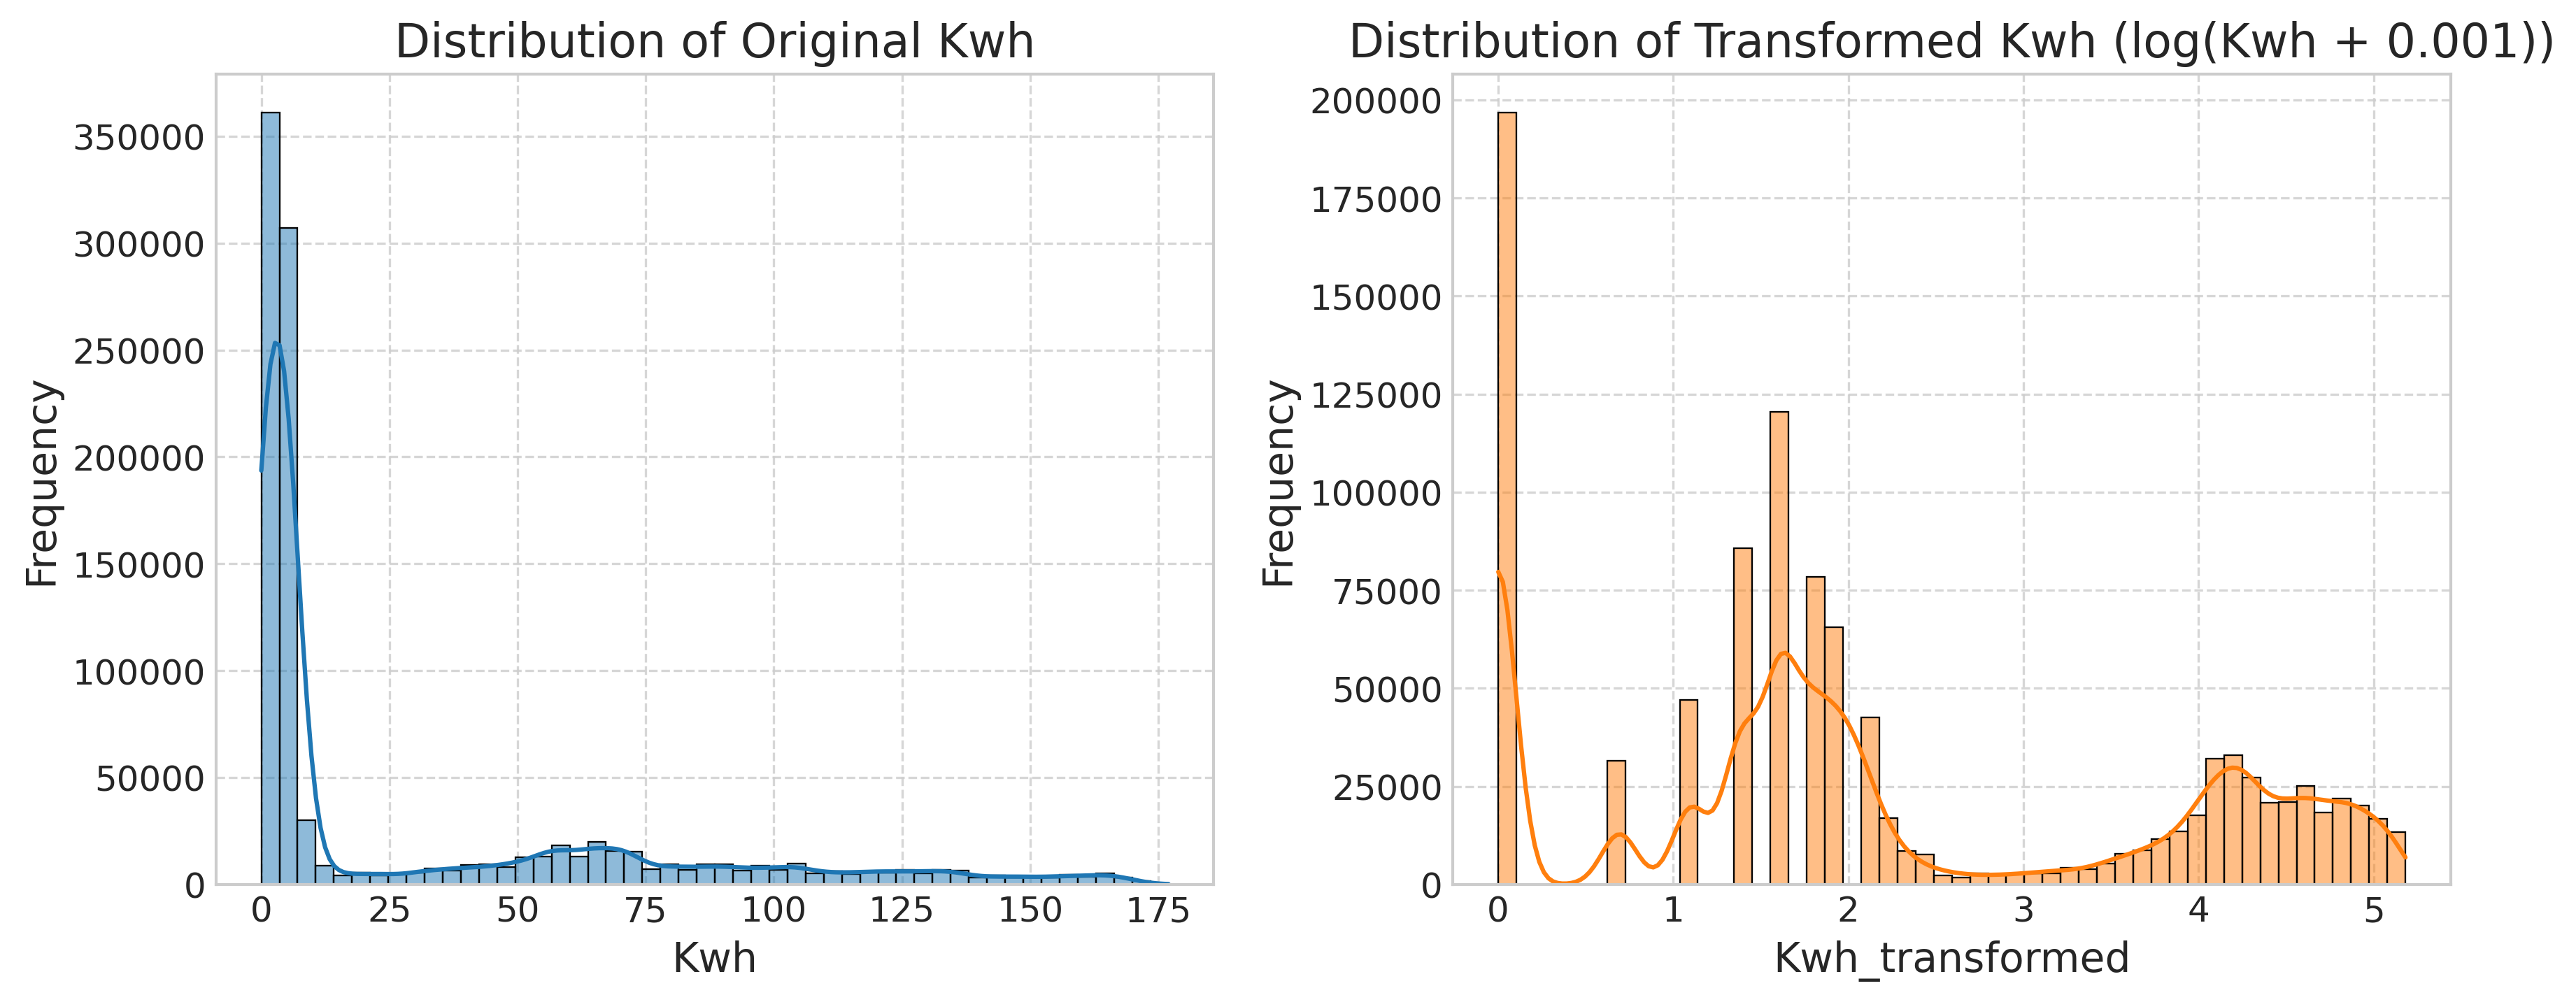

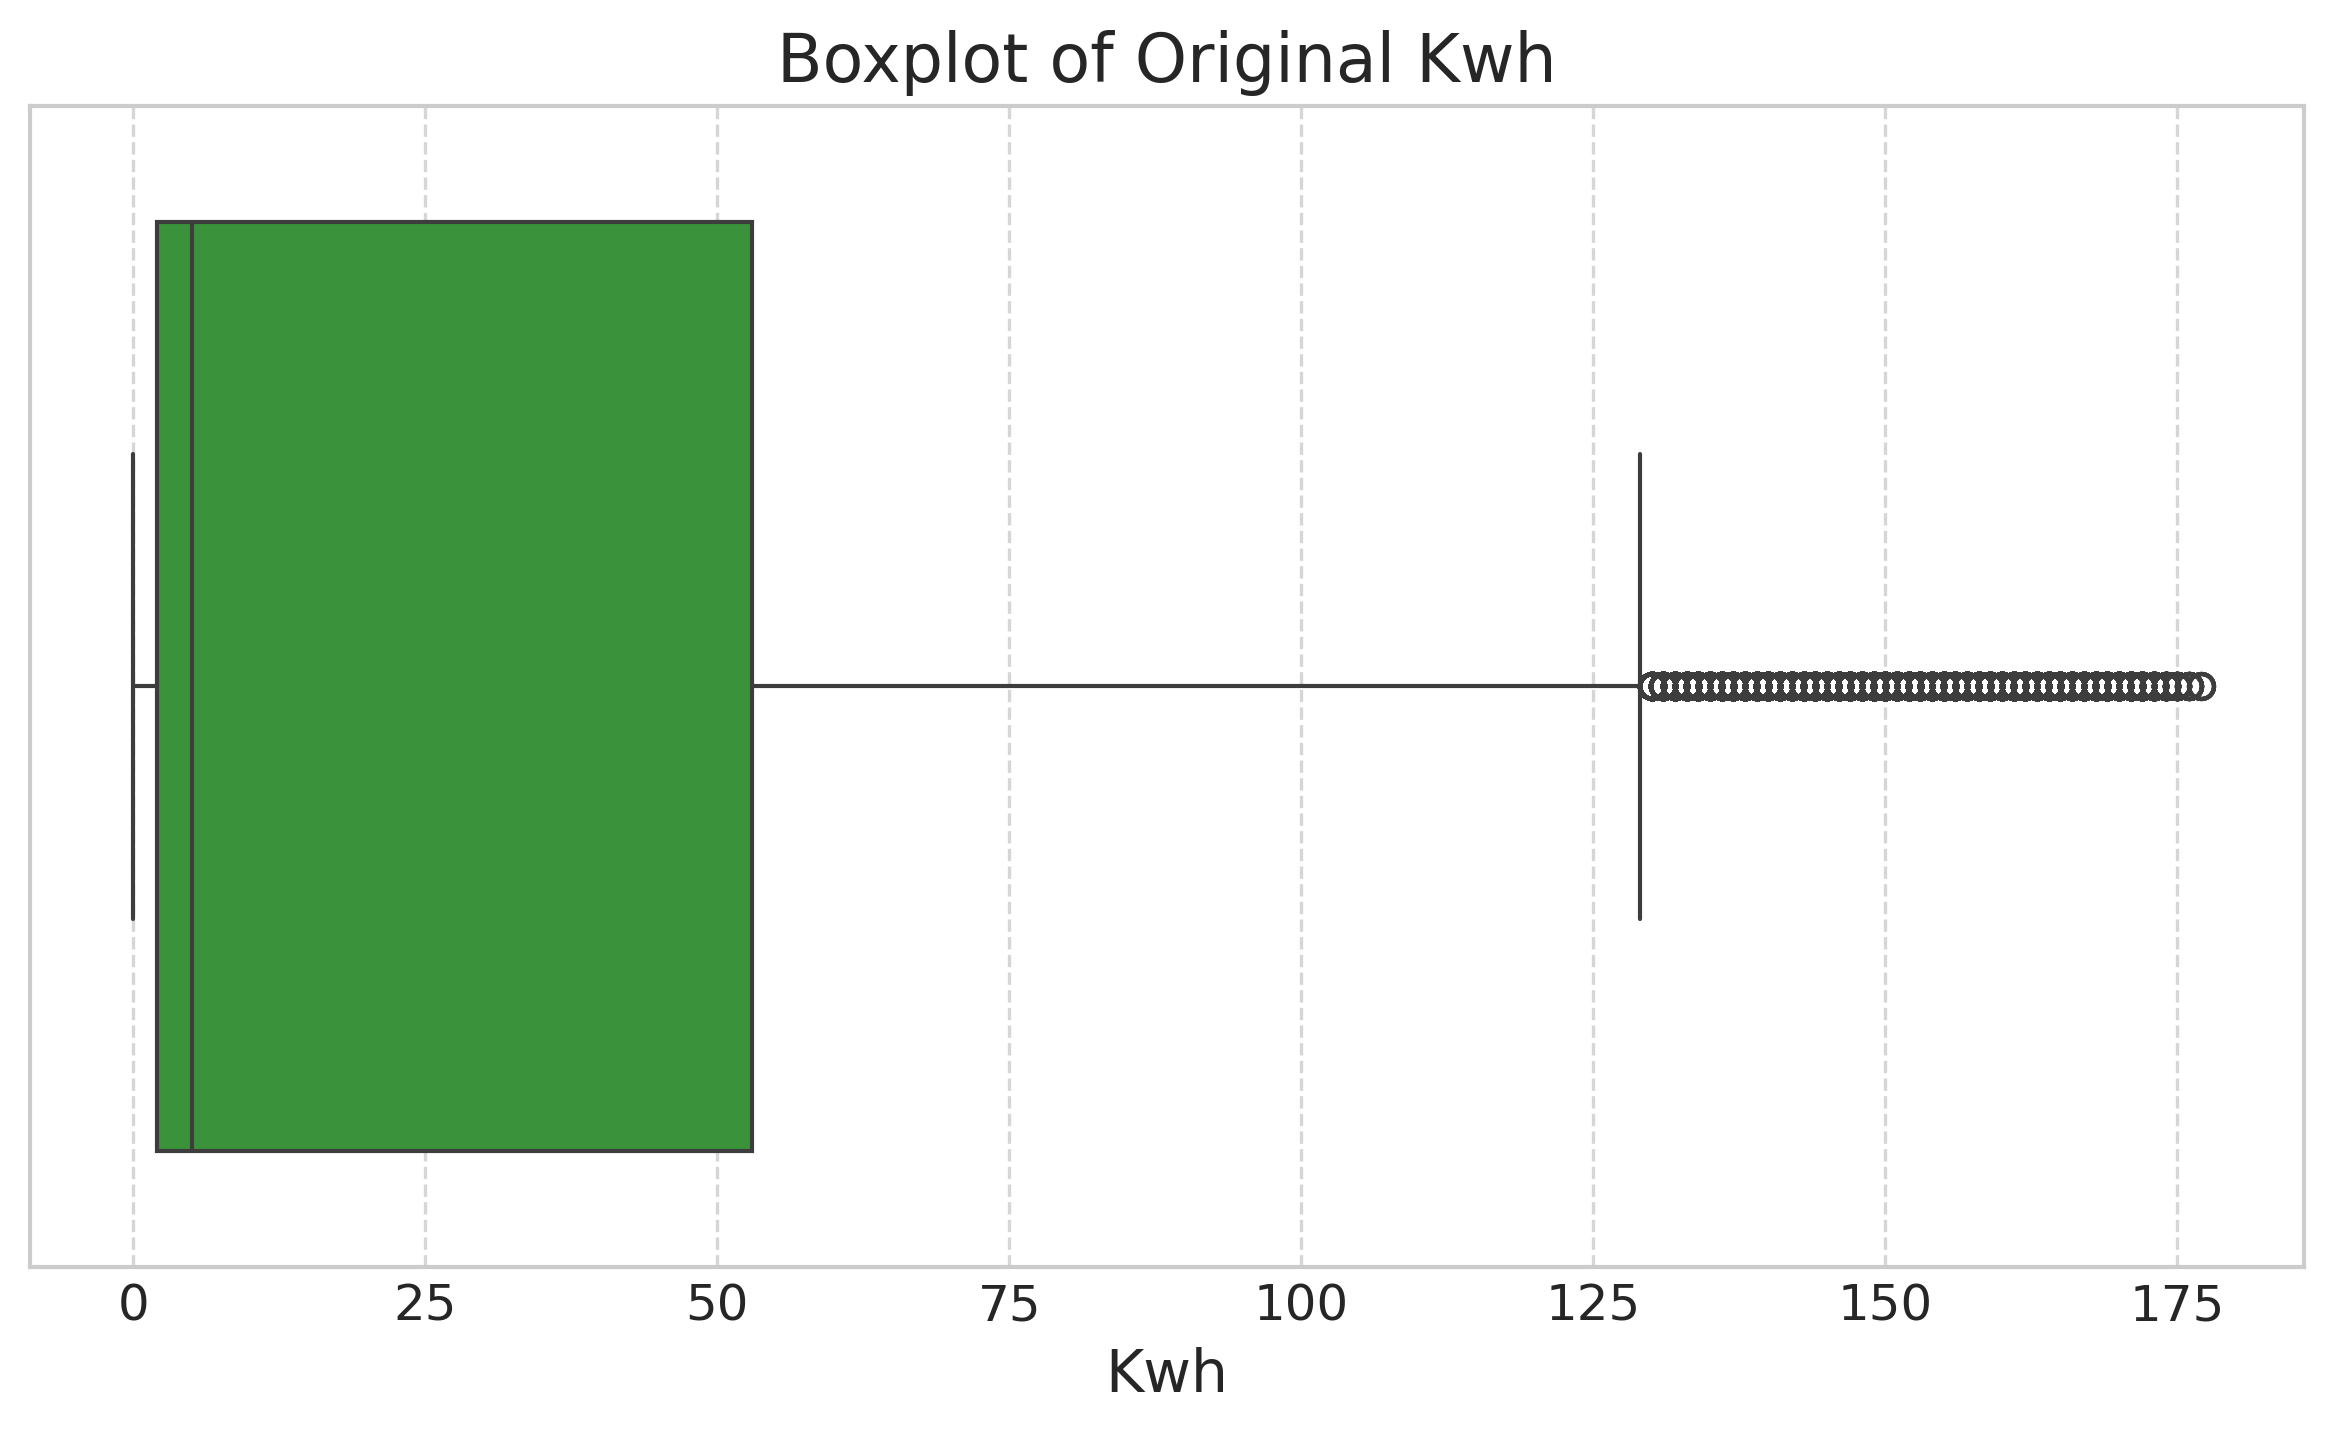

Iteration No: 1 started. Evaluating function at random point.


ValueError: Input contains NaN.

In [6]:
import numpy as np
import pandas as pd
# !pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
# !pip install scikit-learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
# !pip install lightgbm
from lightgbm import LGBMRegressor
from scipy.signal import savgol_filter
import matplotlib.dates as mdates
# !pip install scikit-optimize
from skopt import gp_minimize
# !pip install shap
import shap
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Check if skopt is installed
try:
    from skopt import gp_minimize
except ImportError:
    raise ImportError("scikit-optimize is not installed. Run: pip install scikit-optimize")

# Set seed value for reproducibility
SEED = 42
np.random.seed(SEED)

# Set style for publication-quality plots
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    plt.style.use('classic')
    print("Warning: 'seaborn-v0_8-whitegrid' style not found, using 'classic' style.")

plt.rcParams.update({
    # 'font.family': '',
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.8,
})

# Load the dataset
file_path = 'full-data.csv'  # Adjust the file path
try:
    data = pd.read_csv(file_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Dataset not found at {file_path}. Please check the file path.")

# Convert 'Date Time' to proper datetime format and set as index
# data['DateTime'] = pd.to_datetime(data['DateTime'], format='%Y-%m-%d %H:%M:%S')
data['DateTime'] = pd.to_datetime(data['DateTime'], format='%Y-%m-%d %H:%M')
data.set_index('DateTime', inplace=True)


# F_DATA71: 내부습도 - HumidityIn
# F_DATA72: 내부온도 - TempIn
# F_DATA74: 외부풍속 - WSOut
# F_DATA76: 외부 적산일사량 - TISROut
# F_DATA78: 외부온도 - TempOut


# Data preprocessing
data = data.dropna(subset=['F_DATA71', 'F_DATA72', 'F_DATA74', 'F_DATA76', 'F_DATA78'])
data['F_DATA71'] = np.clip(data['F_DATA71'], 0, 100)  # Humidity [0, 100]
data['F_DATA74'] = np.maximum(data['F_DATA74'], 0)    # Wind speed >= 0
data['F_DATA76'] = np.maximum(data['F_DATA76'], 0)    # Solar radiation >= 0

# Visualize Data Distribution
print("\nKwh Data Distribution Statistics:")
print(data['Kwh'].describe())
print("Number of zero Kwh values:", (data['Kwh'] == 0).sum())
print("Minimum non-zero Kwh value:", data[data['Kwh'] > 0]['Kwh'].min())
print("Percentage of Kwh values <= 0.1:", 100 * len(data[data['Kwh'] <= 0.1]) / len(data))

# Histogram of Kwh and Transformed Kwh
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data['Kwh'], bins=50, kde=True, color='#1f77b4')
plt.title('Distribution of Original Kwh', fontsize=16)
plt.xlabel('Kwh', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.subplot(1, 2, 2)
data['Kwh_transformed'] = np.log1p(data['Kwh'] + 0.001)  # Log transformation
sns.histplot(data['Kwh_transformed'], bins=50, kde=True, color='#ff7f0e')
plt.title('Distribution of Transformed Kwh (log(Kwh + 0.001))', fontsize=16)
plt.xlabel('Kwh_transformed', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.savefig('histogram_kwh.png', dpi=300, bbox_inches='tight')
plt.show()

# Boxplot of Kwh
plt.figure(figsize=(8, 5))
data_reset = data.reset_index(drop=True)
sns.boxplot(x='Kwh', data=data_reset, color='#2ca02c')
plt.title('Boxplot of Original Kwh', fontsize=16)
plt.xlabel('Kwh', fontsize=14)
plt.tight_layout()
plt.savefig('boxplot_kwh.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature Engineering
data['hour'] = data.index.hour
data['month'] = data.index.month
data['day_of_week'] = data.index.dayofweek

# Nonlinear Physics-Based Energy Model
def physics_energy_model(f_data71, f_data72, f_data74, f_data76, f_data78, coeffs):
    delta_t = f_data72 - f_data78
    conduction = coeffs['k'] * delta_t
    h = coeffs['h0'] * (1 + coeffs['c'] * f_data74)
    convection = h * np.power(np.maximum(delta_t, 0), 1.25)
    solar_humidity = coeffs['alpha'] * f_data76 * (1 + coeffs['beta'] * f_data71 / 100)
    total_energy = conduction + convection + solar_humidity
    total_energy_kwh = np.maximum(total_energy * (1 / 1000), 0)
    return total_energy_kwh, conduction, convection, solar_humidity

# Optimize Physics Model Parameters
def objective(coeffs):
    current_coeffs = {
        'k': coeffs[0], 'h0': coeffs[1], 'c': coeffs[2], 'alpha': coeffs[3], 'beta': coeffs[4]
    }
    data['Kwh_physics'], _, _, _ = physics_energy_model(
        data['F_DATA71'], data['F_DATA72'], data['F_DATA74'], data['F_DATA76'], 
        data['F_DATA78'], current_coeffs
    )
    return mean_squared_error(data['Kwh_transformed'], data['Kwh_physics'])

param_ranges = [
    (0.01, 0.5), (0.1, 10.0), (0.01, 0.2), (0.001, 0.1), (0.01, 0.5)
]

result = gp_minimize(objective, param_ranges, n_calls=30, random_state=SEED, verbose=True)

best_coeffs = {
    'k': result.x[0], 'h0': result.x[1], 'c': result.x[2], 'alpha': result.x[3], 'beta': result.x[4]
}
best_mse = result.fun
print(f"Best Coefficients: {best_coeffs}, MSE: {best_mse}")

# Apply Best Coefficients
data['Kwh_physics'], data['conduction'], data['convection'], data['solar_humidity'] = physics_energy_model(
    data['F_DATA71'], data['F_DATA72'], data['F_DATA74'], data['F_DATA76'], data['F_DATA78'], best_coeffs
)
data['residuals'] = data['Kwh_transformed'] - data['Kwh_physics']

# Lagged and Rolling Features
for lag in range(1, 4):
    data[f'Kwh_lag_{lag}'] = data['Kwh_transformed'].shift(lag)
data['Kwh_roll_mean'] = data['Kwh_transformed'].rolling(window=3).mean()
data['Kwh_roll_std'] = data['Kwh_transformed'].rolling(window=3).std()
data.dropna(inplace=True)

# Features and Target
feature_names = ['F_DATA71', 'F_DATA72', 'F_DATA74', 'F_DATA76', 'F_DATA78', 
                 'hour', 'day_of_week', 'month', 'Kwh_physics', 
                 'Kwh_lag_1', 'Kwh_lag_2', 'Kwh_lag_3']
X_ml = data[feature_names]
y_ml = data['residuals'].to_numpy()

# Train-Test Split
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size=0.2, shuffle=False)

# Evaluation Metrics Function with NRMSE and RMSLE
def evaluate_model(y_true, y_pred, n_features, y_range, y_mean):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    nrmse_range = rmse / y_range if y_range > 0 else np.nan
    nrmse_mean = rmse / y_mean if y_mean > 0 else np.nan
    rmsle = np.sqrt(np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred)))) if np.all(y_true > 0) and np.all(y_pred > 0) else np.nan
    r2 = r2_score(y_true, y_pred) if len(y_true) > 1 else np.nan
    mae = mean_absolute_error(y_true, y_pred)
    n = len(y_true)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1) if (n - n_features - 1) > 0 and not np.isnan(r2) else np.nan
    mask = y_true > 0.1  # Avoid transformed offset
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.any(mask) else np.nan
    denominator = np.abs(y_true) + np.abs(y_pred)
    mask_smape = denominator > 0
    smape = np.mean(2 * np.abs(y_true[mask_smape] - y_pred[mask_smape]) / denominator[mask_smape]) * 100 if np.any(mask_smape) else np.nan
    quantiles = [0.1, 0.5, 0.9]
    pinball_losses = {}
    error = y_true - y_pred
    for quantile in quantiles:
        pinball_loss = np.mean(np.where(error >= 0, quantile * error, (quantile - 1) * error)) / y_mean * 100 if y_mean > 0 else np.nan
        pinball_losses[f'pinball_{int(quantile*100)}'] = pinball_loss if not np.isnan(pinball_loss) else 0
    return mse, rmse, nrmse_range, nrmse_mean, rmsle, r2, adjusted_r2, mae, mape, smape, pinball_losses

# Compute range and mean for normalization
y_range = data['residuals'].max() - data['residuals'].min()
y_mean = data['residuals'].mean()

"I attached one model."

from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV
# PI+RF Model with Bayesian Optimization
rf_search_space = {
    'n_estimators': Integer(50, 200),  # Reduced range; fewer trees
    'max_depth': Integer(5, 15),       # Narrower range to limit tree complexity
    'min_samples_split': Integer(10, 30),
    'min_samples_leaf': Integer(5, 15),
    'max_features': Categorical(['sqrt', 'log2']),  # Fewer options, faster computation
    'max_samples': Real(0.7, 0.9)      # Narrower range
}
rf_model = RandomForestRegressor(random_state=SEED, bootstrap=True)
time_split = TimeSeriesSplit(n_splits=5)
bayes_search_rf = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=SEED, bootstrap=True),
    search_spaces=rf_search_space,
    n_iter=20,                         # Reduced from 50
    cv=TimeSeriesSplit(n_splits=3),    # Reduced from 5
    scoring='neg_mean_squared_error',
    n_jobs=-1,                         # Use all CPU cores
    verbose=2,
    random_state=SEED
)
bayes_search_rf.fit(X_train_ml, y_train_ml)
best_rf_model = bayes_search_rf.best_estimator_
print("Best Hyperparameters for PI+RF:", bayes_search_rf.best_params_)

y_train_pred_rf = best_rf_model.predict(X_train_ml)
y_test_pred_rf = best_rf_model.predict(X_test_ml)
final_predictions_train_rf = X_train_ml['Kwh_physics'] + y_train_pred_rf
final_predictions_test_rf = X_test_ml['Kwh_physics'] + y_test_pred_rf

train_metrics_rf = evaluate_model(data['Kwh_transformed'][:len(X_train_ml)], final_predictions_train_rf, X_train_ml.shape[1], y_range, y_mean)
test_metrics_rf = evaluate_model(data['Kwh_transformed'][len(X_train_ml):], final_predictions_test_rf, X_train_ml.shape[1], y_range, y_mean)
print(f"PI+RF Train MSE={train_metrics_rf[0]:.4f}, RMSE={train_metrics_rf[1]:.4f}, NRMSE(range)={train_metrics_rf[2]:.4f}, NRMSE(mean)={train_metrics_rf[3]:.4f}, RMSLE={train_metrics_rf[4]:.4f}, R2={train_metrics_rf[5]:.4f}, Adjusted R2={train_metrics_rf[6]:.4f}, MAE={train_metrics_rf[7]:.4f}, MAPE={train_metrics_rf[8]:.2f}%, sMAPE={train_metrics_rf[9]:.2f}%")
print(f"PI+RF Test MSE={test_metrics_rf[0]:.4f}, RMSE={test_metrics_rf[1]:.4f}, NRMSE(range)={test_metrics_rf[2]:.4f}, NRMSE(mean)={test_metrics_rf[3]:.4f}, RMSLE={test_metrics_rf[4]:.4f}, R2={test_metrics_rf[5]:.4f}, Adjusted R2={test_metrics_rf[6]:.4f}, MAE={test_metrics_rf[7]:.4f}, MAPE={test_metrics_rf[8]:.2f}%, sMAPE={test_metrics_rf[9]:.2f}%")

# RF Feature Importance
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nRandom Forest Feature Importance:")
print(rf_importance)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=rf_importance, color='#1f77b4')
plt.title('Random Forest Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV

# Seed
SEED = 42
np.random.seed(SEED)

# 스타일 설정
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    plt.style.use('classic')

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.8,
})

# 데이터 로드
file_path = 'full-data.csv'
try:
    data = pd.read_csv(file_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Dataset not found at {file_path}.")

# datetime 인덱스 설정
data['DateTime'] = pd.to_datetime(data['DateTime'], format='%Y-%m-%d %H:%M')
data.set_index('DateTime', inplace=True)

# ------------------------
# 1. 중복 인덱스 제거 & NaN 제거
# ------------------------
data = data[~data.index.duplicated(keep='first')]

required_cols = ['Kwh', 'F_DATA71', 'F_DATA72', 'F_DATA74', 'F_DATA76', 'F_DATA78']
data.dropna(subset=required_cols, inplace=True)

# 값 클리핑
data['F_DATA71'] = np.clip(data['F_DATA71'], 0, 100)
data['F_DATA74'] = np.maximum(data['F_DATA74'], 0)
data['F_DATA76'] = np.maximum(data['F_DATA76'], 0)

# Kwh 변환
data['Kwh_transformed'] = np.log1p(data['Kwh'] + 0.001)

# ------------------------
# 2. 물리 기반 모델 정의
# ------------------------
def physics_energy_model(f_data71, f_data72, f_data74, f_data76, f_data78, coeffs):
    delta_t = f_data72 - f_data78
    conduction = coeffs['k'] * delta_t
    h = coeffs['h0'] * (1 + coeffs['c'] * f_data74)
    convection = h * np.power(np.maximum(delta_t, 0), 1.25)
    solar_humidity = coeffs['alpha'] * f_data76 * (1 + coeffs['beta'] * f_data71 / 100)
    total_energy = conduction + convection + solar_humidity
    total_energy_kwh = np.maximum(total_energy / 1000, 0)
    return total_energy_kwh, conduction, convection, solar_humidity

# ------------------------
# 3. objective()에서 NaN 방지
# ------------------------
def objective(coeffs):
    current_coeffs = {
        'k': coeffs[0], 'h0': coeffs[1], 'c': coeffs[2], 'alpha': coeffs[3], 'beta': coeffs[4]
    }
    data['Kwh_physics'], _, _, _ = physics_energy_model(
        data['F_DATA71'], data['F_DATA72'], data['F_DATA74'], data['F_DATA76'], data['F_DATA78'],
        current_coeffs
    )
    valid_mask = data['Kwh_transformed'].notna() & data['Kwh_physics'].notna()
    return mean_squared_error(
        data.loc[valid_mask, 'Kwh_transformed'],
        data.loc[valid_mask, 'Kwh_physics']
    )

# ------------------------
# 4. 물리 모델 최적화
# ------------------------
param_ranges = [
    (0.01, 0.5), (0.1, 10.0), (0.01, 0.2), (0.001, 0.1), (0.01, 0.5)
]
result = gp_minimize(objective, param_ranges, n_calls=30, random_state=SEED, verbose=True)

best_coeffs = {
    'k': result.x[0], 'h0': result.x[1], 'c': result.x[2], 'alpha': result.x[3], 'beta': result.x[4]
}
print(f"Best Coefficients: {best_coeffs}, MSE: {result.fun}")

# ------------------------
# 5. 모델 결과 적용
# ------------------------
data['Kwh_physics'], data['conduction'], data['convection'], data['solar_humidity'] = physics_energy_model(
    data['F_DATA71'], data['F_DATA72'], data['F_DATA74'], data['F_DATA76'], data['F_DATA78'], best_coeffs
)
data['residuals'] = data['Kwh_transformed'] - data['Kwh_physics']

# ------------------------
# 6. Lag, Rolling Features
# ------------------------
for lag in range(1, 4):
    data[f'Kwh_lag_{lag}'] = data['Kwh_transformed'].shift(lag)
data['Kwh_roll_mean'] = data['Kwh_transformed'].rolling(window=3).mean()
data['Kwh_roll_std'] = data['Kwh_transformed'].rolling(window=3).std()
data.dropna(inplace=True)

# ------------------------
# 7. RF 모델 학습
# ------------------------
feature_names = [
    'F_DATA71', 'F_DATA72', 'F_DATA74', 'F_DATA76', 'F_DATA78',
    'hour', 'day_of_week', 'month', 'Kwh_physics',
    'Kwh_lag_1', 'Kwh_lag_2', 'Kwh_lag_3'
]
data['hour'] = data.index.hour
data['month'] = data.index.month
data['day_of_week'] = data.index.dayofweek

X_ml = data[feature_names]
y_ml = data['residuals'].to_numpy()
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size=0.2, shuffle=False)

rf_search_space = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(5, 15),
    'min_samples_split': Integer(10, 30),
    'min_samples_leaf': Integer(5, 15),
    'max_features': Categorical(['sqrt', 'log2']),
    'max_samples': Real(0.7, 0.9)
}
bayes_search_rf = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=SEED, bootstrap=True),
    search_spaces=rf_search_space,
    n_iter=20,
    cv=TimeSeriesSplit(n_splits=3),
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=SEED
)
bayes_search_rf.fit(X_train_ml, y_train_ml)
print("Best Hyperparameters for PI+RF:", bayes_search_rf.best_params_)


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0413
Function value obtained: 6.7610
Current minimum: 6.7610
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0433
Function value obtained: 6.7624
Current minimum: 6.7610
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0504
Function value obtained: 6.2121
Current minimum: 6.2121
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0382
Function value obtained: 6.8528
Current minimum: 6.2121
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0401
Function value obtained: 7.1824
Current minimum: 6.2121
Iteration No: 6 started. Evaluating

In [1]:
"""
Integrated pipeline file: PI optimization + PI+RF + PI+SSA-CNN-LSTM (physics-informed loss)
Features implemented:
 - Physics model parameter optimization (gp_minimize)
 - PI+RandomForest (BayesSearchCV)
 - SSA + CNN-LSTM sequence model predicting transformed Kwh with physics-informed loss
 - Automatic alpha (physics penalty) search using gp_minimize (warm search with reduced epochs)
 - ModelCheckpoint (weights), CSVLogger, and Python logging
 - Saving final metrics and predictions (CSV), saving RF model via joblib

Notes:
 - This script assumes columns for date, target, and sensors exist. It attempts some flexible name mapping.
 - Packages required: numpy, pandas, scikit-learn, scikit-optimize, pyts, tensorflow, matplotlib, seaborn, joblib
   Install missing packages with pip before running.

"""

import os
import logging
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt import BayesSearchCV
from skopt.space import Categorical
from pyts.decomposition import SingularSpectrumAnalysis
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# -------------------------
# User settings (edit these)
# -------------------------
FILE_PATH = 'full-data.csv'   # <-- set your csv file path
DATE_CANDIDATES = ['DateTime', 'REG_DATE', 'date', 'Datetime']
POSSIBLE_TARGETS = ['Kwh', 'F_DATA71', 'F_DATA72', 'F_DATA74', 'F_DATA76', 'F_DATA78']



# Training / search params
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Physics optimization (gp_minimize) calls
PHYSICS_GP_CALLS = 30

# RF bayes search
RF_BAYES_ITER = 20

# SSA / sequence params
WINDOW_SIZE = 60
WINDOW_SSA = 10

# SSA-CNN-LSTM training params
BATCH = 256
EPOCHS_FULL = 200         # final full training epochs
EPOCHS_WARM = 60          # warm search epochs (faster) for alpha search
PATIENCE = 20
LR = 0.004

# Alpha search (physics loss weight) - gp_minimize parameters
ALPHA_SEARCH_CALLS = 8    # number of alpha evaluations during warm search (small to save time)
ALPHA_BOUNDS = (0.0, 1.0)

# Directories
CHECKPOINT_DIR = 'checkpoints'
LOG_DIR = 'logs'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# Logger
logger = logging.getLogger('pipeline_logger')
logger.setLevel(logging.INFO)
if not logger.handlers:
    fh = logging.FileHandler(os.path.join(LOG_DIR, 'pipeline.log'))
    fh.setLevel(logging.INFO)
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    fmt = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    fh.setFormatter(fmt)
    ch.setFormatter(fmt)
    logger.addHandler(fh)
    logger.addHandler(ch)

# -------------------------
# Helper functions
# -------------------------

def inv_log1p(arr):
    return np.expm1(arr) - 0.001

# physics energy model returns kWh
def physics_energy_model_kwh(f_data71, f_data72, f_data74, f_data76, f_data78, coeffs):
    delta_t = f_data72 - f_data78
    conduction = coeffs['k'] * delta_t
    h = coeffs['h0'] * (1 + coeffs['c'] * f_data74)
    convection = h * np.power(np.maximum(delta_t, 0), 1.25)
    solar_humidity = coeffs['alpha'] * f_data76 * (1 + coeffs['beta'] * f_data71 / 100)
    total_energy = conduction + convection + solar_humidity
    total_energy_kwh = np.maximum(total_energy / 1000.0, 0.0)
    return total_energy_kwh, conduction, convection, solar_humidity

# physics-informed loss factory for Keras (operates on scaled transformed values)
def physics_informed_loss(alpha):
    def loss(y_true, y_pred):
        # y_true: two columns concatenated [actual_scaled, phys_scaled]
        y_actual = tf.expand_dims(y_true[:, 0], axis=-1)
        phys_for_target = tf.expand_dims(y_true[:, 1], axis=-1)
        mse_term = tf.reduce_mean(tf.square(y_pred - y_actual))
        phys_term = tf.reduce_mean(tf.square(y_pred - phys_for_target))
        return mse_term + alpha * phys_term
    return loss

# Build sequence model (same architecture used for alpha search)
def build_sequence_model(input_shape, lr=LR):
    tf.keras.backend.clear_session()
    model = Sequential([
        Conv1D(16, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        LSTM(32),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer=Adam(lr), loss='mse')  # loss overwritten when compiled with physics_informed_loss
    return model

# -------------------------
# 1) Load data and detect columns
# -------------------------
logger.info('Loading data from: %s', FILE_PATH)
df = pd.read_csv(FILE_PATH)
# find date column
date_col = None
for c in DATE_CANDIDATES:
    if c in df.columns:
        date_col = c
        break
if date_col is None:
    try:
        # try parse first column
        df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
        date_col = df.columns[0]
    except Exception as e:
        logger.error('No datetime column found. Provide one of %s or ensure first column is datetime.', DATE_CANDIDATES)
        raise

logger.info('Using date column: %s', date_col)
df[date_col] = pd.to_datetime(df[date_col])
df = df.set_index(date_col).sort_index()

# detect target column
target_col = None
for t in POSSIBLE_TARGETS:
    if t in df.columns:
        target_col = t
        break
if target_col is None:
    logger.error('No target column found among %s', POSSIBLE_TARGETS)
    raise ValueError('No target column found')
logger.info('Detected target column: %s', target_col)

# sensor flexible mapping
col_map = {
    'hum': ['F_DATA71', 'abso_humid', 'humidity', 'humid'],
    'temp_in': ['F_DATA72', 'temp_inside', 'temp_in'],
    'wind': ['F_DATA74', 'wind_velo', 'wind_speed'],
    'solar': ['F_DATA76', 'solar_radiation_outside', 'solar', 'TISROut'],
    'temp_out': ['F_DATA78', 'temp_outside', 'temp_out']
}
found = {}
for key, candidates in col_map.items():
    for c in candidates:
        if c in df.columns:
            found[key] = c
            break
if len(found) < len(col_map):
    missing = set(col_map.keys()) - set(found.keys())
    logger.error('Missing sensor columns for: %s', missing)
    raise ValueError(f'Missing sensor columns for: {missing}')

# rename
df = df.rename(columns={found['hum']:'F_DATA71', found['temp_in']:'F_DATA72', found['wind']:'F_DATA74',
                        found['solar']:'F_DATA76', found['temp_out']:'F_DATA78', target_col:'Kwh'})

# -------------------------
# 2) Preprocessing: dedupe, dropna, clipping, transform
# -------------------------
df = df[~df.index.duplicated(keep='first')]
required_cols = ['Kwh','F_DATA71','F_DATA72','F_DATA74','F_DATA76','F_DATA78']
df.dropna(subset=required_cols, inplace=True)

# clip/clean
df['F_DATA71'] = np.clip(df['F_DATA71'], 0, 100)
df['F_DATA74'] = np.maximum(df['F_DATA74'], 0)
df['F_DATA76'] = np.maximum(df['F_DATA76'], 0)

# transformed target (log1p)
df['Kwh_transformed'] = np.log1p(df['Kwh'] + 0.001)
logger.info('Data preprocessed: %d rows remain', len(df))

# -------------------------
# 3) Physics optimization via gp_minimize (optimize coefficients)
# -------------------------
logger.info('Starting physics parameter optimization (gp_minimize, %d calls)...', PHYSICS_GP_CALLS)

def objective_physics(coeffs):
    current = {'k': coeffs[0], 'h0': coeffs[1], 'c': coeffs[2], 'alpha': coeffs[3], 'beta': coeffs[4]}
    kwh_phys_kwh, _, _, _ = physics_energy_model_kwh(df['F_DATA71'].values, df['F_DATA72'].values,
                                                      df['F_DATA74'].values, df['F_DATA76'].values,
                                                      df['F_DATA78'].values, current)
    kwh_phys_trans = np.log1p(kwh_phys_kwh + 0.001)
    mask = df['Kwh_transformed'].notna() & ~np.isnan(kwh_phys_trans)
    return mean_squared_error(df.loc[mask, 'Kwh_transformed'].values, kwh_phys_trans[mask])

param_ranges = [(0.01, 0.5), (0.1, 10.0), (0.01, 0.2), (0.001, 0.1), (0.01, 0.5)]
res_phys = gp_minimize(objective_physics, param_ranges, n_calls=PHYSICS_GP_CALLS, random_state=SEED, verbose=False)
best_coeffs = {'k': res_phys.x[0], 'h0': res_phys.x[1], 'c': res_phys.x[2], 'alpha': res_phys.x[3], 'beta': res_phys.x[4]}
logger.info('Physics opt done. Best coeffs: %s, MSE: %.6f', best_coeffs, res_phys.fun)

# apply physics model to all rows
kwh_phys_kwh_all, cond_all, conv_all, sol_all = physics_energy_model_kwh(df['F_DATA71'].values, df['F_DATA72'].values,
                                                                          df['F_DATA74'].values, df['F_DATA76'].values,
                                                                          df['F_DATA78'].values, best_coeffs)
df['Kwh_physics_kwh'] = kwh_phys_kwh_all
df['Kwh_physics'] = np.log1p(df['Kwh_physics_kwh'] + 0.001)  # transformed physics baseline
# residual
df['residual'] = df['Kwh_transformed'] - df['Kwh_physics']

# -------------------------
# 4) PI + RF (residual prediction)
# -------------------------
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

feature_names = ['F_DATA71','F_DATA72','F_DATA74','F_DATA76','F_DATA78','hour','day_of_week','month','Kwh_physics']
X = df[feature_names].copy()
y_res = df['residual'].values

split_idx = int(len(X) * 0.8)
X_train_rf, X_test_rf = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_rf, y_test_rf = y_res[:split_idx], y_res[split_idx:]

logger.info('Starting PI+RF Bayesian optimization (n_iter=%d)...', RF_BAYES_ITER)
from skopt.space import Integer, Real as SkReal
rf_search_space = {
    'n_estimators': Integer(50,200),
    'max_depth': Integer(5,15),
    'min_samples_split': Integer(10,30),
    'min_samples_leaf': Integer(5,15),
    'max_features': Categorical(['sqrt','log2']),
    'max_samples': SkReal(0.7,0.95)
}
bayes_rf = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=SEED, bootstrap=True),
    search_spaces=rf_search_space,
    n_iter=RF_BAYES_ITER,
    cv=TimeSeriesSplit(n_splits=3),
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0,
    random_state=SEED
)
bayes_rf.fit(X_train_rf, y_train_rf)
best_rf = bayes_rf.best_estimator_
logger.info('Best RF params: %s', bayes_rf.best_params_)
# save RF model
joblib.dump(best_rf, os.path.join(CHECKPOINT_DIR, 'rf_model.joblib'))
logger.info('Saved RF model to %s', os.path.join(CHECKPOINT_DIR, 'rf_model.joblib'))

# RF predict residual + combine with physics (transformed)
y_pred_train_res_rf = best_rf.predict(X_train_rf)
y_pred_test_res_rf = best_rf.predict(X_test_rf)
pred_train_transformed_rf = X_train_rf['Kwh_physics'].values + y_pred_train_res_rf
pred_test_transformed_rf = X_test_rf['Kwh_physics'].values + y_pred_test_res_rf

# evaluate RF
def print_metrics_arr(y_true, y_pred, label=''):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred) if len(y_true) > 1 else np.nan
    logger.info('[%s] MSE=%.6f, RMSE=%.6f, MAE=%.6f, R2=%.6f', label, mse, rmse, mae, r2)

y_train_true_trans = df['Kwh_transformed'].values[:len(pred_train_transformed_rf)]
y_test_true_trans = df['Kwh_transformed'].values[len(pred_train_transformed_rf):len(pred_train_transformed_rf)+len(pred_test_transformed_rf)]
print_metrics_arr(y_train_true_trans, pred_train_transformed_rf, 'PI+RF Train (transformed)')
print_metrics_arr(y_test_true_trans, pred_test_transformed_rf, 'PI+RF Test  (transformed)')

# original kWh eval
pred_test_kwh_rf = inv_log1p(pred_test_transformed_rf)
y_test_kwh_true_rf = inv_log1p(y_test_true_trans)
print_metrics_arr(y_test_kwh_true_rf, pred_test_kwh_rf, 'PI+RF Test (original Kwh)')

# -------------------------
# 5) SSA preprocessing for sequence model (predict transformed Kwh directly)
# -------------------------
ssa_cols = ['Kwh_transformed', 'Kwh_physics', 'F_DATA71','F_DATA74','F_DATA76','F_DATA72','F_DATA78']
df_ssa = df[ssa_cols].dropna()

ssa = SingularSpectrumAnalysis(window_size=WINDOW_SSA)
ssa_comps = []
for col in df_ssa.columns:
    arr = df_ssa[col].values.reshape(1, -1)
    comps = ssa.fit_transform(arr)    # shape (1, n_components, n_timestamps)
    main = comps[0,0,:]
    ssa_comps.append(main)
ssa_main = np.array(ssa_comps).T  # shape (n_timestamps, n_features)

scaler_ssa = MinMaxScaler()
ssa_scaled = scaler_ssa.fit_transform(ssa_main)
idx_phys = list(df_ssa.columns).index('Kwh_physics')

# create sequences

def create_sequences(data, ws):
    X_seq = []
    y_seq = []
    phys_targets = []
    for i in range(len(data) - ws):
        X_seq.append(data[i:i+ws, :])
        y_seq.append(data[i+ws, 0])
        phys_targets.append(data[i+ws, idx_phys])
    return np.array(X_seq), np.array(y_seq), np.array(phys_targets)

X_seq, y_seq, phys_targets = create_sequences(ssa_scaled, WINDOW_SIZE)

n = len(X_seq)
i_train = int(n * 0.7)
i_val = int(n * 0.9)
X_tr, y_tr = X_seq[:i_train], y_seq[:i_train]
X_val, y_val = X_seq[i_train:i_val], y_seq[i_train:i_val]
X_te, y_te = X_seq[i_val:], y_seq[i_val:]
phys_tr = phys_targets[:i_train]
phys_val = phys_targets[i_train:i_val]
phys_te = phys_targets[i_val:]

logger.info('Sequence shapes: %s, %s, %s', X_tr.shape, X_val.shape, X_te.shape)

# prepare concatenated y for physics loss (two columns)
y_tr_concat = np.vstack([y_tr, phys_tr]).T
y_val_concat = np.vstack([y_val, phys_val]).T
y_te_concat = np.vstack([y_te, phys_te]).T

input_shape = (WINDOW_SIZE, X_seq.shape[2])

# -------------------------
# 6) Alpha search (warm) using gp_minimize. For each alpha, train for EPOCHS_WARM and return best val_loss
# -------------------------
logger.info('Starting alpha search (gp_minimize, calls=%d) using warm training (epochs=%d)...', ALPHA_SEARCH_CALLS, EPOCHS_WARM)

# closure to train and return val loss
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

def train_and_eval_for_alpha(alpha, epochs=EPOCHS_WARM):
    tf.keras.backend.clear_session()
    model = Sequential([
        Conv1D(16, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        LSTM(32),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer=Adam(LR), loss=physics_informed_loss(alpha))

    ckpt_path = os.path.join(CHECKPOINT_DIR, f'best_alpha_{alpha:.4f}_warm.weights.h5')
    csv_path = os.path.join(LOG_DIR, f'history_alpha_{alpha:.4f}_warm.csv')
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=max(3, PATIENCE//4), restore_best_weights=True),
        ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, save_weights_only=True),
        CSVLogger(csv_path)
    ]
    history = model.fit(X_tr, np.array(y_tr_concat), validation_data=(X_val, np.array(y_val_concat)),
                        epochs=epochs, batch_size=BATCH, callbacks=callbacks, verbose=0)
    val_loss = min(history.history.get('val_loss', [np.inf]))
    logger.info('Alpha %.4f -> best val_loss %.6f', alpha, val_loss)
    return float(val_loss)

# objective for gp_minimize

def objective_alpha(x):
    alpha = float(x[0])
    return train_and_eval_for_alpha(alpha, epochs=EPOCHS_WARM)

res_alpha = gp_minimize(objective_alpha, [ALPHA_BOUNDS], n_calls=ALPHA_SEARCH_CALLS, n_initial_points=3, random_state=SEED, verbose=False)
best_alpha = float(res_alpha.x[0])
logger.info('Alpha search done. Best alpha: %.6f, val_loss: %.6f', best_alpha, res_alpha.fun)

# -------------------------
# 7) Final training with best_alpha (full epochs) and save final checkpoint
# -------------------------
logger.info('Final training with best_alpha=%.6f for %d epochs...', best_alpha, EPOCHS_FULL)
tf.keras.backend.clear_session()
model_final = Sequential([
    Conv1D(16, 3, activation='relu', input_shape=input_shape),
    MaxPooling1D(2),
    LSTM(32),
    Dropout(0.1),
    Dense(1)
])
model_final.compile(optimizer=Adam(LR), loss=physics_informed_loss(best_alpha))

ckpt_final = os.path.join(CHECKPOINT_DIR, f'final_model_alpha_{best_alpha:.4f}.weights.h5')
csv_final = os.path.join(LOG_DIR, f'final_history_alpha_{best_alpha:.4f}.csv')
callbacks_final = [
    EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
    ModelCheckpoint(ckpt_final, monitor='val_loss', save_best_only=True, save_weights_only=True),
    CSVLogger(csv_final)
]

history_final = model_final.fit(X_tr, np.array(y_tr_concat), validation_data=(X_val, np.array(y_val_concat)),
                                epochs=EPOCHS_FULL, batch_size=BATCH, callbacks=callbacks_final, verbose=1)

# save final weights
model_final.save_weights(ckpt_final)
logger.info('Saved final model weights to %s', ckpt_final)

# -------------------------
# 8) Evaluate on test set and save metrics/predictions
# -------------------------
logger.info('Evaluating final model on test set...')
y_pred_scaled = model_final.predict(X_te).flatten()
# inverse scaling: scaled transformed -> transformed

def inv_first(scaler, arr, col_index=0):
    n = arr.shape[0]
    dummy = np.zeros((n, scaler.scale_.shape[0]))
    dummy[:, col_index] = arr
    return scaler.inverse_transform(dummy)[:, col_index]

# Note: y_pred_scaled are scaled values corresponding to transformed Kwh
# use scaler_ssa fitted earlier: it's present in this script's scope as scaler_ssa
try:
    y_pred_transformed = inv_first(scaler_ssa, y_pred_scaled, col_index=0)
    y_test_transformed_true = inv_first(scaler_ssa, y_te, col_index=0)
except Exception as e:
    logger.error('Error during inverse scaling: %s', e)
    raise

y_pred_kwh = inv_log1p(y_pred_transformed)
y_test_kwh_true = inv_log1p(y_test_transformed_true)

metrics = {
    'MSE_transformed': mean_squared_error(y_test_transformed_true, y_pred_transformed),
    'RMSE_transformed': np.sqrt(mean_squared_error(y_test_transformed_true, y_pred_transformed)),
    'MAE_transformed': mean_absolute_error(y_test_transformed_true, y_pred_transformed),
    'R2_transformed': r2_score(y_test_transformed_true, y_pred_transformed),
    'MSE_kwh': mean_squared_error(y_test_kwh_true, y_pred_kwh),
    'RMSE_kwh': np.sqrt(mean_squared_error(y_test_kwh_true, y_pred_kwh)),
    'MAE_kwh': mean_absolute_error(y_test_kwh_true, y_pred_kwh),
    'R2_kwh': r2_score(y_test_kwh_true, y_pred_kwh)
}
metrics_df = pd.DataFrame([metrics])
metrics_csv = os.path.join(LOG_DIR, f'final_test_metrics_alpha_{best_alpha:.4f}.csv')
metrics_df.to_csv(metrics_csv, index=False)
logger.info('Saved final test metrics to %s', metrics_csv)

# save predictions with timestamps (align to original df index)
start_idx = WINDOW_SIZE + i_val
pred_dates = df.index[start_idx : start_idx + len(y_pred_kwh)]

pred_df = pd.DataFrame({'date': pred_dates, 'y_true_kwh': y_test_kwh_true, 'y_pred_kwh': y_pred_kwh})
pred_csv = os.path.join(LOG_DIR, f'predictions_alpha_{best_alpha:.4f}.csv')
pred_df.to_csv(pred_csv, index=False)
logger.info('Saved predictions to %s', pred_csv)

logger.info('Pipeline finished successfully.')


2025-08-14 15:07:26.730506: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 15:07:26.778394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755151646.813867   21634 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755151646.825601   21634 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755151646.868969   21634 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Epoch 1/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - loss: 0.0012 - val_loss: 4.1366e-05
Epoch 2/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 3.9006e-04 - val_loss: 2.1536e-04
Epoch 3/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 3.7701e-04 - val_loss: 4.1190e-05
Epoch 4/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 3.6815e-04 - val_loss: 2.2230e-05
Epoch 5/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 4.1185e-04 - val_loss: 3.8665e-05
Epoch 6/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 3.6713e-04 - val_loss: 1.7927e-05
Epoch 7/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 3.5931e-04 - val_loss: 3.2184e-05
Epoch 8/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 3.5744e-04 - val_loss: 3.0880e-05
Epoch 9/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 3.5198e-04 - val_loss: 3.9223e-05
Epoch 10/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 3.4619e-04 - val_loss: 6.1160e-05
Epoch 11/200


2025-08-14 16:41:05,235 - INFO - Saved final model weights to checkpoints/final_model_alpha_0.0000.weights.h5
2025-08-14 16:41:05,236 - INFO - Evaluating final model on test set...


2976/2976 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2025-08-14 16:41:14,789 - INFO - Saved final test metrics to logs/final_test_metrics_alpha_0.0000.csv
2025-08-14 16:41:15,094 - INFO - Saved predictions to logs/predictions_alpha_0.0000.csv
2025-08-14 16:41:15,095 - INFO - Pipeline finished successfully.


Index(['date', 'y_true_kwh', 'y_pred_kwh'], dtype='object')


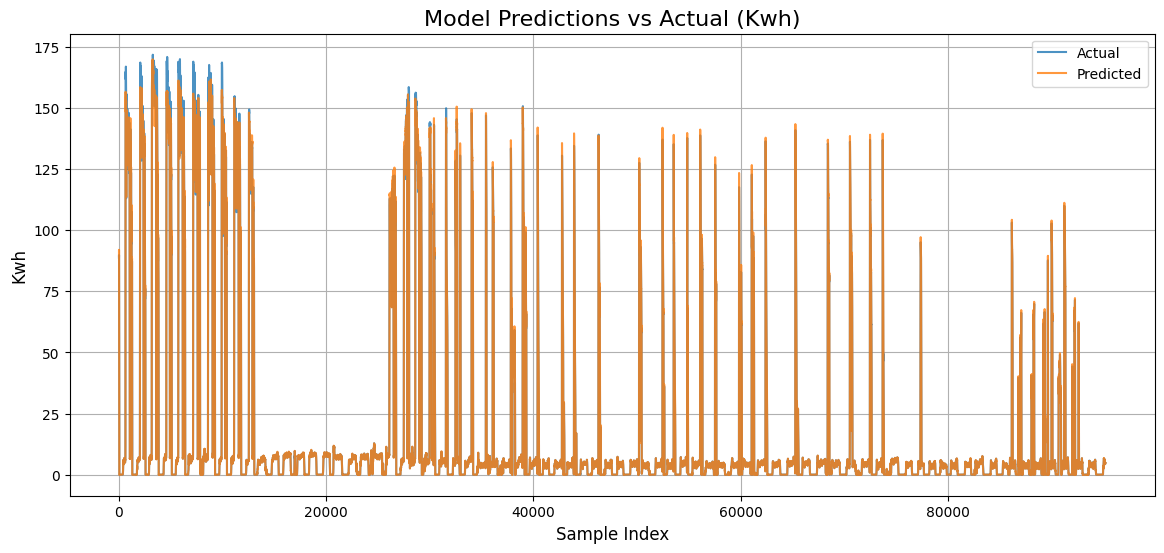

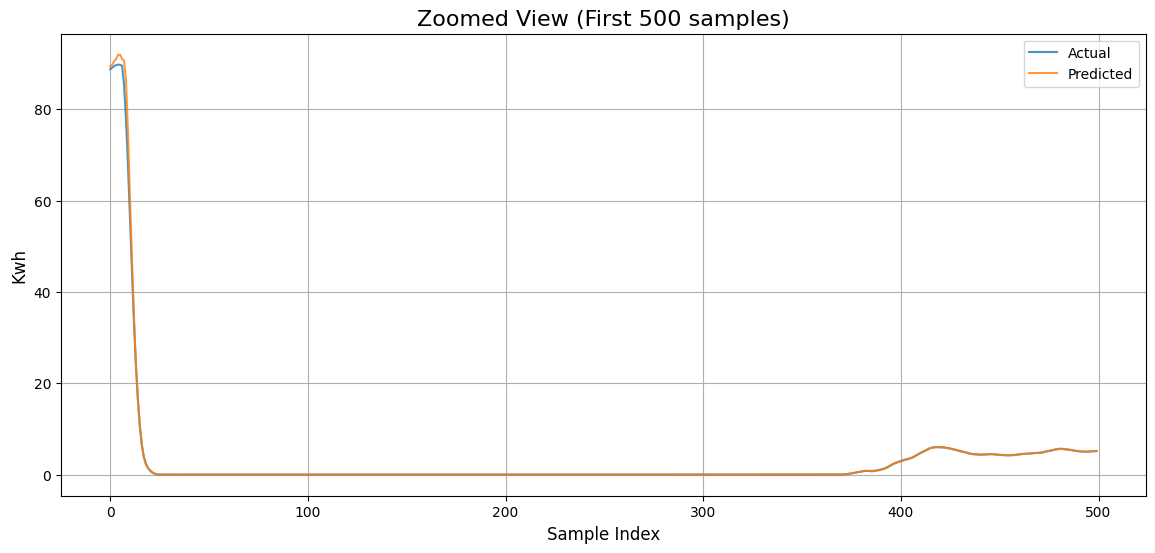

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 예측 파일 로드
pred_file = 'logs/predictions_alpha_0.0000.csv'  # 경로 확인 필요
df_pred = pd.read_csv(pred_file)

# CSV에 들어 있는 컬럼 확인
print(df_pred.columns)  # 예: ['y_true', 'y_pred']

# 원본 단위(Kwh)로 시각화
plt.figure(figsize=(14,6))
plt.plot(df_pred['y_true_kwh'], label='Actual', alpha=0.8)
plt.plot(df_pred['y_pred_kwh'], label='Predicted', alpha=0.8)
plt.title('Model Predictions vs Actual (Kwh)', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Kwh', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# 확대 구간(예: 처음 500 샘플만)
plt.figure(figsize=(14,6))
plt.plot(df_pred['y_true_kwh'][:500], label='Actual', alpha=0.8)
plt.plot(df_pred['y_pred_kwh'][:500], label='Predicted', alpha=0.8)
plt.title('Zoomed View (First 500 samples)', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Kwh', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 예측 CSV 불러오기
df_pred = pd.read_csv(predictions_path)

# 메트릭 계산
mse = mean_squared_error(df_pred['y_true_kwh'], df_pred['y_pred_kwh'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_pred['y_true_kwh'], df_pred['y_pred_kwh'])
r2 = r2_score(df_pred['y_true_kwh'], df_pred['y_pred_kwh'])

# 로그 출력
logger.info("[Final Test Metrics (original Kwh)] MSE=%.6f, RMSE=%.6f, MAE=%.6f, R2=%.6f", mse, rmse, mae, r2)

# CSV 저장
metrics_path = predictions_path.replace('.csv', '_metrics.csv')
pd.DataFrame([{
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}]).to_csv(metrics_path, index=False)
logger.info("Saved final test metrics to %s", metrics_path)


NameError: name 'predictions_path' is not defined

In [2]:
'''
! 필요 라이브러리
scikit-learn tensorflow numpy pandas
Tensorflow는 공식 홈페이지에서 리눅스 기반으로 설치 방법 필요

! 학습 출력은 output 폴더 아래에 timestamp 순서로 저장됨

- 2025 09 16 업데이트: PI+RF 모델의 정확도 낮음 (R^2: 0.5...) ==> 개선 필요함
'''

import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV

from pyts.decomposition import SingularSpectrumAnalysis

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint

import joblib


# =========================================================
# 0) 사용자 설정
# =========================================================

# 데이터셋: full-data.csv

FILE_PATH = 'full-data.csv'      # <-- CSV 데이터 경로
DATE_CANDIDATES = ['DateTime', 'REG_DATE', 'date', 'Datetime']

# 타깃/센서 컬럼 후보 (유연 매핑)
# F_DATA71 = 절대습도
# F_DATA72 = 내부 온도(기온)
# F_DATA74 = 풍속
# F_DATA76 = 외부 일사량
# F_DATA78 = 실외 온도

POSSIBLE_TARGETS = ['Kwh', 'pwr_cnsmp']
SENSOR_MAP = {
    'hum':      ['F_DATA71', 'abso_humid', 'humidity', 'humid'],
    'temp_in':  ['F_DATA72', 'temp_inside', 'temp_in'],
    'wind':     ['F_DATA74', 'wind_velo', 'wind_speed'],
    'solar':    ['F_DATA76', 'solar_radiation_outside', 'solar', 'TISROut'],
    'temp_out': ['F_DATA78', 'temp_outside', 'temp_out']
}

# 재현성
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 물리계수 최적화
PHYSICS_GP_CALLS = 30            # gp_minimize 호출 횟수

# RF 탐색
RF_BAYES_ITER = 20

# SSA/시퀀스
WINDOW_SIZE = 60
WINDOW_SSA = 10

# LSTM 학습
BATCH = 256
EPOCHS_FULL = 200
EPOCHS_WARM = 60
PATIENCE = 15           # [수정] 조기 종료 patience 감소
LR = 0.004
DROPOUT_RATE = 0.2      # [수정] Dropout 비율 조정

# Alpha(물리 손실 가중치)
SEARCH_ALPHA = False             # True면 자동탐색, False면 고정값 사용
FIXED_ALPHA = 0.0               # SEARCH_ALPHA=False일 때 사용
ALPHA_BOUNDS = (0.0, 1.0)       # 탐색 구간
ALPHA_SEARCH_CALLS = 8          # warm search 호출 횟수 (작게: 빠름)

# [수정] 각 실행마다 고유한 출력 폴더 생성
BASE_OUTPUT_DIR = 'output'
RUN_DIR = os.path.join(BASE_OUTPUT_DIR, datetime.now().strftime('run_%Y%m%d_%H%M%S'))
CHECKPOINT_DIR = os.path.join(RUN_DIR, 'checkpoints')
LOG_DIR = os.path.join(RUN_DIR, 'logs')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# 로거 설정
logger = logging.getLogger('pipeline_logger')
logger.setLevel(logging.INFO)
if not logger.handlers:
    fh = logging.FileHandler(os.path.join(RUN_DIR, 'pipeline.log')) # [수정] 실행별 로그 파일
    fh.setLevel(logging.INFO)
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    fmt = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    fh.setFormatter(fmt)
    ch.setFormatter(fmt)
    logger.addHandler(fh)
    logger.addHandler(ch)

logger.info(f"===== New Run Initialized: {RUN_DIR} =====")


# =========================================================
# 1) 유틸 함수
# =========================================================
def inv_log1p(arr):
    """log1p(x+0.001)를 원복 (x 단위: kWh)"""
    return np.expm1(arr) - 0.001

def physics_energy_model_kwh(f_data71, f_data72, f_data74, f_data76, f_data78, coeffs):
    """
    단순 물리 모델 (k, h0, c, alpha, beta)
    반환 단위: kWh (0 하한)
    """
    delta_t = f_data72 - f_data78
    conduction = coeffs['k'] * delta_t
    h = coeffs['h0'] * (1 + coeffs['c'] * f_data74)
    convection = h * np.power(np.maximum(delta_t, 0), 1.25)
    solar_humidity = coeffs['alpha'] * f_data76 * (1 + coeffs['beta'] * f_data71 / 100.0)
    total_energy = conduction + convection + solar_humidity
    total_energy_kwh = np.maximum(total_energy / 1000.0, 0.0)
    return total_energy_kwh, conduction, convection, solar_humidity

def physics_informed_loss(alpha):
    """
    y_true는 [y_actual_scaled, y_physics_scaled] 2열을 concat해서 전달.
    loss = MSE(y_pred, y_actual) + alpha * MSE(y_pred, y_physics)
    """
    def loss(y_true, y_pred):
        y_actual = tf.expand_dims(y_true[:, 0], axis=-1)
        y_phys   = tf.expand_dims(y_true[:, 1], axis=-1)
        mse_term  = tf.reduce_mean(tf.square(y_pred - y_actual))
        phys_term = tf.reduce_mean(tf.square(y_pred - y_phys))
        return mse_term + alpha * phys_term
    return loss

def build_sequence_model(input_shape, lr=LR):
    tf.keras.backend.clear_session()
    model = Sequential([
        Conv1D(16, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        LSTM(32),
        Dropout(DROPOUT_RATE), # [수정] Dropout 비율 적용
        Dense(1)
    ])
    # 실제 학습 시 compile 때 loss를 물리손실로 교체
    model.compile(optimizer=Adam(lr), loss='mse')
    return model

def create_sequences(data, ws, idx_phys_col):
    """
    data: (T, F) scaled array (col0=Kwh_transformed, col[idx_phys_col]=Kwh_physics)
    """
    X_seq, y_seq, phys_seq = [], [], []
    for i in range(len(data) - ws):
        X_seq.append(data[i:i+ws, :])
        y_seq.append(data[i+ws, 0])
        phys_seq.append(data[i+ws, idx_phys_col])
    return np.array(X_seq), np.array(y_seq), np.array(phys_seq)

def print_metrics(y_true, y_pred, tag):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred) if len(y_true) > 1 else np.nan
    logger.info("[%s] MSE=%.6f, RMSE=%.6f, MAE=%.6f, R2=%.6f", tag, mse, rmse, mae, r2)


# =========================================================
# 2) 데이터 로드 & 컬럼 감지/정리
# =========================================================
logger.info('Loading data from: %s', FILE_PATH)
df = pd.read_csv(FILE_PATH)

# 날짜 컬럼 찾기
date_col = None
for c in DATE_CANDIDATES:
    if c in df.columns:
        date_col = c
        break
if date_col is None:
    try:
        df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
        date_col = df.columns[0]
    except Exception:
        raise ValueError(f"No datetime column. Provide one of {DATE_CANDIDATES} or set first column to datetime.")

df[date_col] = pd.to_datetime(df[date_col])
df = df.set_index(date_col).sort_index()

# 타깃 컬럼 찾기
target_col = None
for t in POSSIBLE_TARGETS:
    if t in df.columns:
        target_col = t
        break
if target_col is None:
    raise ValueError(f"No target column among {POSSIBLE_TARGETS}")

# 센서 유연 매핑
found = {}
for key, cand in SENSOR_MAP.items():
    for c in cand:
        if c in df.columns:
            found[key] = c
            break
missing_keys = [k for k in SENSOR_MAP.keys() if k not in found]
if missing_keys:
    raise ValueError(f"Missing sensor columns for: {missing_keys}")

# 표준 컬럼명으로 리네임
df = df.rename(columns={
    found['hum']:'F_DATA71',
    found['temp_in']:'F_DATA72',
    found['wind']:'F_DATA74',
    found['solar']:'F_DATA76',
    found['temp_out']:'F_DATA78',
    target_col:'Kwh'
})

# 중복 타임스탬프 제거, 결측 제거/클리핑
df = df[~df.index.duplicated(keep='first')]
needed = ['Kwh', 'F_DATA71','F_DATA72','F_DATA74','F_DATA76','F_DATA78']
df.dropna(subset=needed, inplace=True)
df['F_DATA71'] = np.clip(df['F_DATA71'], 0, 100)
df['F_DATA74'] = np.maximum(df['F_DATA74'], 0)
df['F_DATA76'] = np.maximum(df['F_DATA76'], 0)

# 변환 타깃
df['Kwh_transformed'] = np.log1p(df['Kwh'] + 0.001)
logger.info('Data preprocessed: %d rows', len(df))


# =========================================================
# 3) 물리계수 최적화 (gp_minimize)
# =========================================================
logger.info('Physics coefficient optimization (gp_minimize, calls=%d)', PHYSICS_GP_CALLS)

def objective_physics(coeffs):
    current = {'k': coeffs[0], 'h0': coeffs[1], 'c': coeffs[2], 'alpha': coeffs[3], 'beta': coeffs[4]}
    kwh_phys_kwh, _, _, _ = physics_energy_model_kwh(
        df['F_DATA71'].values, df['F_DATA72'].values, df['F_DATA74'].values,
        df['F_DATA76'].values, df['F_DATA78'].values, current
    )
    kwh_phys_trans = np.log1p(kwh_phys_kwh + 0.001)
    mask = df['Kwh_transformed'].notna() & ~np.isnan(kwh_phys_trans)
    return mean_squared_error(df.loc[mask, 'Kwh_transformed'].values, kwh_phys_trans[mask])

param_ranges = [(0.01, 0.5), (0.1, 10.0), (0.01, 0.2), (0.001, 0.1), (0.01, 0.5)]
res_phys = gp_minimize(objective_physics, param_ranges, n_calls=PHYSICS_GP_CALLS, random_state=SEED, verbose=False)
best_coeffs = {'k': res_phys.x[0], 'h0': res_phys.x[1], 'c': res_phys.x[2], 'alpha': res_phys.x[3], 'beta': res_phys.x[4]}
logger.info('Physics opt done. Best coeffs: %s, MSE: %.6f', best_coeffs, res_phys.fun)

# 물리 예측치 계산 & 잔차
kwh_phys_kwh_all, *_ = physics_energy_model_kwh(
    df['F_DATA71'].values, df['F_DATA72'].values, df['F_DATA74'].values,
    df['F_DATA76'].values, df['F_DATA78'].values, best_coeffs
)
df['Kwh_physics_kwh'] = kwh_phys_kwh_all
df['Kwh_physics'] = np.log1p(df['Kwh_physics_kwh'] + 0.001)
df['residual'] = df['Kwh_transformed'] - df['Kwh_physics']


# =========================================================
# 4) PI + RF (잔차 예측)
# =========================================================
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

feature_names = ['F_DATA71','F_DATA72','F_DATA74','F_DATA76','F_DATA78','hour','day_of_week','month','Kwh_physics']
X_rf = df[feature_names].copy()
y_res = df['residual'].values

# 시계열 순서를 유지하며 데이터 분할
split_idx = int(len(X_rf) * 0.8)
X_train_rf, X_test_rf = X_rf.iloc[:split_idx], X_rf.iloc[split_idx:]
y_train_rf, y_test_rf = y_res[:split_idx], y_res[split_idx:]

logger.info('PI+RF BayesSearch (n_iter=%d)', RF_BAYES_ITER)
rf_search_space = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(5, 15),
    'min_samples_split': Integer(10, 30),
    'min_samples_leaf': Integer(5, 15),
    'max_features': Categorical(['sqrt','log2']),
    'max_samples': Real(0.7, 0.95)
}
# CV에 시계열 교차검증 사용
bayes_rf = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=SEED, bootstrap=True),
    search_spaces=rf_search_space,
    n_iter=RF_BAYES_ITER,
    cv=TimeSeriesSplit(n_splits=3),
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0,
    random_state=SEED
)
bayes_rf.fit(X_train_rf, y_train_rf)
best_rf = bayes_rf.best_estimator_
logger.info('Best RF params: %s', bayes_rf.best_params_)

# 저장
rf_path = os.path.join(CHECKPOINT_DIR, 'rf_model.joblib') # [수정] 경로 변경
joblib.dump(best_rf, rf_path)
logger.info('Saved RF model -> %s', rf_path)

# 예측/결합(변환공간)
y_pred_train_res = best_rf.predict(X_train_rf)
y_pred_test_res  = best_rf.predict(X_test_rf)
pred_train_trans = X_train_rf['Kwh_physics'].values + y_pred_train_res
pred_test_trans  = X_test_rf['Kwh_physics'].values + y_pred_test_res

y_train_true_trans = df['Kwh_transformed'].values[:len(pred_train_trans)]
y_test_true_trans  = df['Kwh_transformed'].values[len(pred_train_trans):len(pred_train_trans)+len(pred_test_trans)]
print_metrics(y_train_true_trans, pred_train_trans, 'PI+RF Train (transformed)')
print_metrics(y_test_true_trans,  pred_test_trans,  'PI+RF Test  (transformed)')

# 원 단위 평가
pred_test_kwh = inv_log1p(pred_test_trans)
y_test_kwh_true = inv_log1p(y_test_true_trans)
print_metrics(y_test_kwh_true, pred_test_kwh, 'PI+RF Test (original Kwh)')


# =========================================================
# 5) SSA 전처리 & 시퀀스 데이터 생성
# =========================================================
ssa_cols = ['Kwh_transformed','Kwh_physics','F_DATA71','F_DATA74','F_DATA76','F_DATA72','F_DATA78']
df_ssa = df[ssa_cols].dropna()
ssa = SingularSpectrumAnalysis(window_size=WINDOW_SSA)

# 각 컬럼에서 첫 번째 SSA 성분 사용
ssa_main_cols = []
for col in df_ssa.columns:
    arr = df_ssa[col].values.reshape(1, -1)
    comp = ssa.fit_transform(arr)[0, 0, :]   # (1, n_comp, T) -> 첫 성분
    ssa_main_cols.append(comp)
ssa_main = np.array(ssa_main_cols).T   # (T, F)

scaler_ssa = MinMaxScaler()
ssa_scaled = scaler_ssa.fit_transform(ssa_main)

idx_phys_col = list(df_ssa.columns).index('Kwh_physics')
X_seq, y_seq, phys_seq = create_sequences(ssa_scaled, WINDOW_SIZE, idx_phys_col)

# 시계열 순서를 유지하며 데이터 분할 (70% train, 20% validation, 10% test)
n = len(X_seq)
i_train = int(n * 0.7)
i_val   = int(n * 0.9)

X_tr, y_tr, phys_tr = X_seq[:i_train], y_seq[:i_train], phys_seq[:i_train]
X_va, y_va, phys_va = X_seq[i_train:i_val], y_seq[i_train:i_val], phys_seq[i_train:i_val]
X_te, y_te, phys_te = X_seq[i_val:], y_seq[i_val:], phys_seq[i_val:]

logger.info('Sequence shapes: %s, %s, %s', X_tr.shape, X_va.shape, X_te.shape)

# y_true를 [actual, physics]로 합쳐 물리손실 입력 구성
y_tr_concat = np.column_stack([y_tr, phys_tr])
y_va_concat = np.column_stack([y_va, phys_va])
y_te_concat = np.column_stack([y_te, phys_te])

input_shape = (WINDOW_SIZE, X_seq.shape[2])


# =========================================================
# 6) Alpha 선택 (자동탐색 or 고정)
# =========================================================
if SEARCH_ALPHA:
    logger.info('Starting alpha search (warm epochs=%d, calls=%d, bounds=%s)', EPOCHS_WARM, ALPHA_SEARCH_CALLS, ALPHA_BOUNDS)

    # skopt 제한: n_calls >= n_initial_points (디폴트 10). 안전하게 설정
    n_init = max(3, min(10, ALPHA_SEARCH_CALLS))
    n_calls = max(ALPHA_SEARCH_CALLS, n_init)

    def train_and_eval_for_alpha(alpha, epochs=EPOCHS_WARM):
        tf.keras.backend.clear_session()
        model = build_sequence_model(input_shape, lr=LR)
        model.compile(optimizer=Adam(LR), loss=physics_informed_loss(alpha))

        # [수정] 경로 변경
        ckpt = os.path.join(CHECKPOINT_DIR, f'best_alpha_{alpha:.4f}_warm.weights.h5')
        csv  = os.path.join(LOG_DIR, f'history_alpha_{alpha:.4f}_warm.csv')
        cbs = [
            EarlyStopping(monitor='val_loss', patience=max(3, PATIENCE//4), restore_best_weights=True),
            ModelCheckpoint(ckpt, monitor='val_loss', save_best_only=True, save_weights_only=True),
            CSVLogger(csv)
        ]
        hist = model.fit(
            X_tr, y_tr_concat,
            validation_data=(X_va, y_va_concat),
            epochs=epochs, batch_size=BATCH,
            callbacks=cbs, verbose=0
        )
        best = float(np.min(hist.history.get('val_loss', [np.inf])))
        logger.info('alpha=%.4f -> val_loss=%.6f', alpha, best)
        return best

    def objective_alpha(x):
        a = float(x[0])
        return train_and_eval_for_alpha(a, epochs=EPOCHS_WARM)

    res_alpha = gp_minimize(objective_alpha, [ALPHA_BOUNDS],
                              n_calls=n_calls, n_initial_points=n_init,
                              random_state=SEED, verbose=False)
    best_alpha = float(res_alpha.x[0])
    logger.info('Alpha search done. best_alpha=%.6f (val_loss=%.6f)', best_alpha, res_alpha.fun)
else:
    best_alpha = float(FIXED_ALPHA)
    logger.info('Alpha fixed to %.6f (SEARCH_ALPHA=False)', best_alpha)


# =========================================================
# 7) 최종 학습 (best_alpha) & 체크포인트 저장
# =========================================================
logger.info('Final training with alpha=%.6f (epochs=%d, patience=%d)', best_alpha, EPOCHS_FULL, PATIENCE)
tf.keras.backend.clear_session()
model_final = build_sequence_model(input_shape, lr=LR)
model_final.compile(optimizer=Adam(LR), loss=physics_informed_loss(best_alpha))

# [수정] 경로 변경
ckpt_final = os.path.join(CHECKPOINT_DIR, f'final_model_alpha_{best_alpha:.4f}.weights.h5')
csv_final  = os.path.join(LOG_DIR, f'final_history_alpha_{best_alpha:.4f}.csv')
cbs_final = [
    EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True), # [수정] 변경된 patience 적용
    ModelCheckpoint(ckpt_final, monitor='val_loss', save_best_only=True, save_weights_only=True),
    CSVLogger(csv_final)
]
history = model_final.fit(
    X_tr, y_tr_concat,
    validation_data=(X_va, y_va_concat),
    epochs=EPOCHS_FULL, batch_size=BATCH,
    callbacks=cbs_final, verbose=1
)

# 최종 가중치 저장(보장)
model_final.save_weights(ckpt_final)
logger.info('Saved final model weights -> %s', ckpt_final)


# =========================================================
# 8) 테스트 평가 & 예측 저장 (CSV/PNG)
# =========================================================
logger.info('Evaluating final model on test set...')
y_pred_scaled = model_final.predict(X_te, verbose=0).flatten()

# scaler_ssa 역변환(변환공간)
def inv_first(scaler, arr, col_index=0):
    n = arr.shape[0]
    dummy = np.zeros((n, scaler.scale_.shape[0]))
    dummy[:, col_index] = arr
    return scaler.inverse_transform(dummy)[:, col_index]

y_pred_transformed = inv_first(scaler_ssa, y_pred_scaled, col_index=0)
y_test_transformed = inv_first(scaler_ssa, y_te,          col_index=0)

# 원단위(kWh) 복원
y_pred_kwh = inv_log1p(y_pred_transformed)
y_true_kwh = inv_log1p(y_test_transformed)

# [추가] 최종 모델 성능 콘솔 출력
logger.info("===== Final SSA-CNN-LSTM Model Performance =====")
print_metrics(y_test_transformed, y_pred_transformed, 'SSA-CNN-LSTM Test (transformed)')
print_metrics(y_true_kwh, y_pred_kwh, 'SSA-CNN-LSTM Test (original Kwh)')

# 메트릭 CSV 저장
metrics = {
    'MSE_transformed': mean_squared_error(y_test_transformed, y_pred_transformed),
    'RMSE_transformed': np.sqrt(mean_squared_error(y_test_transformed, y_pred_transformed)),
    'MAE_transformed': mean_absolute_error(y_test_transformed, y_pred_transformed),
    'R2_transformed': r2_score(y_test_transformed, y_pred_transformed),
    'MSE_kwh': mean_squared_error(y_true_kwh, y_pred_kwh),
    'RMSE_kwh': np.sqrt(mean_squared_error(y_true_kwh, y_pred_kwh)),
    'MAE_kwh': mean_absolute_error(y_true_kwh, y_pred_kwh),
    'R2_kwh': r2_score(y_true_kwh, y_pred_kwh)
}
metrics_df = pd.DataFrame([metrics])
metrics_csv = os.path.join(LOG_DIR, f'final_test_metrics_alpha_{best_alpha:.4f}.csv') # [수정] 경로 변경
metrics_df.to_csv(metrics_csv, index=False)
logger.info('Saved final test metrics -> %s', metrics_csv)

# 타임스탬프 정렬 (df_ssa 기준)
# df_ssa 길이 = T, 시퀀스 생성 시 타깃의 첫 인덱스는 WINDOW_SIZE
# 테스트 구간 시작 위치 = WINDOW_SIZE + i_val
start_idx = WINDOW_SIZE + i_val
end_idx   = start_idx + len(y_pred_kwh)
pred_dates = df_ssa.index[start_idx:end_idx]

# 예측 결과 CSV 저장
pred_df = pd.DataFrame({
    'date': pred_dates,
    'y_true_kwh': y_true_kwh,
    'y_pred_kwh': y_pred_kwh,
    'y_true_transformed': y_test_transformed,
    'y_pred_transformed': y_pred_transformed
})
pred_csv = os.path.join(LOG_DIR, f'predictions_alpha_{best_alpha:.4f}.csv') # [수정] 경로 변경
pred_df.to_csv(pred_csv, index=False)
logger.info('Saved predictions -> %s', pred_csv)

# [추가] PNG 시각화 1: 스케일링된 공간에서의 예측 비교
plt.figure(figsize=(14, 6))
plt.plot(y_te, label='Actual Scaled', alpha=0.8)
plt.plot(y_pred_scaled, label='Predicted Scaled', linestyle='--', alpha=0.8)
plt.title(f'Scaled Prediction vs Actual (Test Set, alpha={best_alpha:.4f})')
plt.xlabel('Sample Index (Test Set)')
plt.ylabel('MinMax Scaled Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
png_path_scaled = os.path.join(LOG_DIR, f'scaled_prediction_comparison_alpha_{best_alpha:.4f}.png') # [수정] 경로 변경
plt.savefig(png_path_scaled, dpi=200)
plt.close()
logger.info('Saved scaled prediction plot -> %s', png_path_scaled)

# PNG 시각화 2: 원본 단위(kWh) 예측 비교
plt.figure(figsize=(14, 6))
plt.plot(pred_df['date'], pred_df['y_true_kwh'], label='Actual (kWh)', linewidth=1.8, alpha=0.85)
plt.plot(pred_df['date'], pred_df['y_pred_kwh'], label='Predicted (kWh)', linewidth=1.8, alpha=0.85, linestyle='--')
plt.title(f'PI+SSA-CNN-LSTM Predictions (alpha={best_alpha:.4f})')
plt.xlabel('Time')
plt.ylabel('Power (kWh)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
png_path = os.path.join(LOG_DIR, f'kwh_predictions_alpha_{best_alpha:.4f}.png') # [수정] 경로 변경
plt.savefig(png_path, dpi=200)
plt.close()
logger.info('Saved kWh prediction plot -> %s', png_path)

logger.info('Pipeline finished successfully.')

2025-08-18 18:37:19,022 - INFO - ===== New Run Initialized: output/run_20250818_183719 =====
2025-08-18 18:37:19,027 - INFO - Loading data from: full-data.csv
2025-08-18 18:37:20,239 - INFO - Data preprocessed: 952251 rows
2025-08-18 18:37:20,240 - INFO - Physics coefficient optimization (gp_minimize, calls=30)
2025-08-18 18:37:25,950 - INFO - Physics opt done. Best coeffs: {'k': 0.5, 'h0': 10.0, 'c': 0.2, 'alpha': 0.1, 'beta': 0.5}, MSE: 5.756884
2025-08-18 18:37:26,245 - INFO - PI+RF BayesSearch (n_iter=20)
2025-08-18 18:52:19,023 - INFO - Best RF params: OrderedDict([('max_depth', 9), ('max_features', 'log2'), ('max_samples', 0.7262147896381759), ('min_samples_leaf', 9), ('min_samples_split', 14), ('n_estimators', 118)])
2025-08-18 18:52:19,052 - INFO - Saved RF model -> output/run_20250818_183719/checkpoints/rf_model.joblib
2025-08-18 18:52:20,941 - INFO - [PI+RF Train (transformed)] MSE=1.157338, RMSE=1.075796, MAE=0.803959, R2=0.547439
2025-08-18 18:52:20,955 - INFO - [PI+RF Test

Epoch 1/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - loss: 0.0022 - val_loss: 6.4625e-05
Epoch 2/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 8.3876e-04 - val_loss: 1.4266e-04
Epoch 3/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 8.1306e-04 - val_loss: 1.5289e-04
Epoch 4/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 8.0155e-04 - val_loss: 1.0990e-04
Epoch 5/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 8.0094e-04 - val_loss: 1.4815e-04
Epoch 6/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 7.7493e-04 - val_loss: 5.1064e-05
Epoch 7/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 7.6184e-04 - val_loss: 1.1806e-04
Epoch 8/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 7.5945e-04 - val_loss: 1.8097e-05
Epoch 9/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 7.5709e-04 - val_loss: 1.2503e-04
Epoch 10/200
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 7.5430e-04 - val_loss: 3.5402e-05
Epoch 11/200


2025-08-18 19:03:19,233 - INFO - Saved final model weights -> output/run_20250818_183719/checkpoints/final_model_alpha_0.0000.weights.h5
2025-08-18 19:03:19,234 - INFO - Evaluating final model on test set...
2025-08-18 19:03:27,723 - INFO - ===== Final SSA-CNN-LSTM Model Performance =====
2025-08-18 19:03:27,731 - INFO - [SSA-CNN-LSTM Test (transformed)] MSE=0.000523, RMSE=0.022861, MAE=0.017746, R2=0.999757
2025-08-18 19:03:27,733 - INFO - [SSA-CNN-LSTM Test (original Kwh)] MSE=1.484682, RMSE=1.218475, MAE=0.348014, R2=0.999012
2025-08-18 19:03:27,743 - INFO - Saved final test metrics -> output/run_20250818_183719/logs/final_test_metrics_alpha_0.0000.csv
2025-08-18 19:03:28,161 - INFO - Saved predictions -> output/run_20250818_183719/logs/predictions_alpha_0.0000.csv
2025-08-18 19:03:28,577 - INFO - Saved scaled prediction plot -> output/run_20250818_183719/logs/scaled_prediction_comparison_alpha_0.0000.png
2025-08-18 19:03:28,894 - INFO - Saved kWh prediction plot -> output/run_20250